<a href="https://colab.research.google.com/github/LabSWPP12023S2G2/TPInicial/blob/main/mental-health-post-COVID19-arg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

# Carga de dataset
url = 'https://raw.githubusercontent.com/LabSWPP12023S2G2/TPInicial/main/datasetUNC.csv'
data = pd.read_csv(url, delimiter=';')
columns_to_drop = ['SUB PERIODS', 'SEX']
data = data.drop(columns=columns_to_drop)
data = data.dropna(axis=0)
data.drop(data[data['PROVINCE'] == 'Otro'].index, inplace=True)
data.drop(data[data['PROVINCE'] == 'other'].index, inplace=True)
data.drop(data[data['EDUCATION'] == 'Otro'].index, inplace=True)

# Asignaciones para columnas no númericas
assignment_mapping = {
    'MENTAL DISORDER HISTORY': {'no': 0, 'yes': 50},
    'EDUCATION': {
        'Completed postgraduate': 30,
        'Incomplete tertiary or university': 60,
        'Completed high school': 70,
        'Incomplete postgraduate': 40,
        'Completed tertiary or university': 50,
        'Incomplete high school': 80,
        'Incomplete elementary school': 100,
        'Completed elementary school': 90
    },
    'SUIC ATTEMPT HISTORY': {'ideation': 50, 'no': 0, 'yes': 100},
    'LIVING WITH SOMEBODY': {'no': 20, 'yes': 0},
    'ECONOMIC INCOME': {'yes': 0, 'no': 50}
}

# Aplicamos las asignaciones
for column, mapping in assignment_mapping.items():
    data[column] = data[column].map(mapping)

#ocurrences = data['PROVINCE'].value_counts()
#print(ocurrences)

# Función para asignar una región a cada provincia
def assign_region(province):
    if province in ['Corrientes', 'Chaco', 'Misiones', 'Formosa', 'Entre Ríos']:
        return 'Nordeste-Litoral'
    elif province in ['Tucumán', 'Jujuy', 'Salta', 'Catamarca', 'Santiago del Estero']:
        return 'Noroeste'
    elif province in ['San Luis', 'San Juan', 'Mendoza', 'La Rioja']:
        return 'Cuyo'
    elif province in ['Neuquén', 'Río Negro', 'La Pampa']:
        return 'Patagonia Centro-Norte'
    elif province in ['Tierra del Fuego', 'Santa Cruz', 'Chubut']:
        return 'Patagonia Centro-Sur'
    elif province == 'Santa Fe':
        return 'Santa Fe'
    elif province == 'Buenos Aires provincia':
        return 'Buenos Aires'
    elif province == 'Córdoba':
        return 'Córdoba'
    else:
        return 'CABA'

# Aplicamos la función a la columna 'PROVINCE' y guardamos el resultado en una nueva columna 'REGION'
data['REGION'] = data['PROVINCE'].apply(assign_region)

# Crea un LabelEncoder para codificar la columna 'REGION'
label_encoder = LabelEncoder()
data['REGION ENCODED'] = label_encoder.fit_transform(data['REGION'])

In [181]:
# Calcula la mediana de las variables excepto "SUIC RISK"
median_except_suic_risk = data.drop(['REGION ENCODED', 'PROVINCE', 'REGION'], axis=1).mean(axis=1)

# Agrega la columna calculada al DataFrame
data['PROM SUIC'] = median_except_suic_risk

In [182]:
data_ref = data[['SUIC RISK', 'PROM SUIC']]

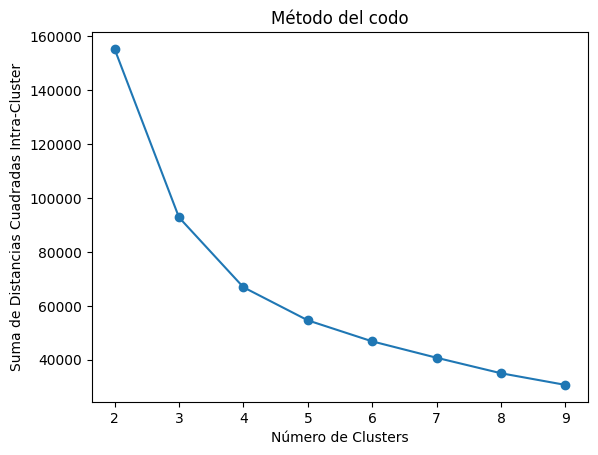

In [152]:
inertia_values = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    kmeans.fit(data_ref)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia_values, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Distancias Cuadradas Intra-Cluster')
plt.title('Método del codo')
plt.show()

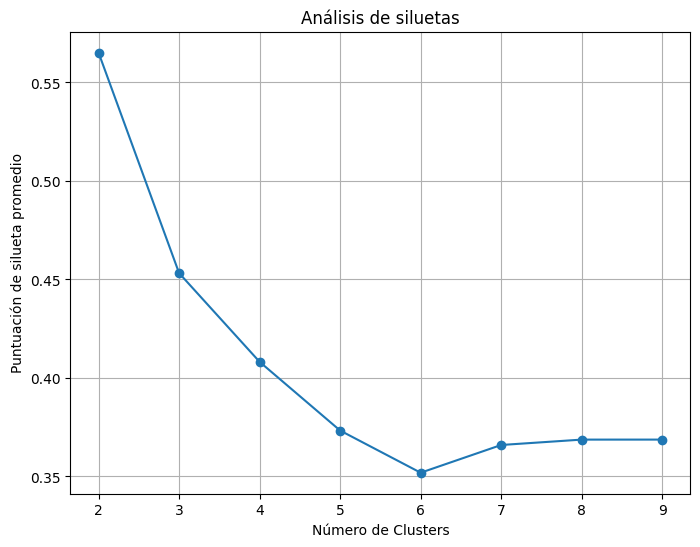

In [153]:
# Calcula las puntuaciones para el análisis de siluetas
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    cluster_labels = kmeans.fit_predict(data_ref)
    silhouette_avg = silhouette_score(data_ref, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(data_ref, cluster_labels)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de silueta promedio')
plt.title('Análisis de siluetas')
plt.grid(True)
plt.show()

In [183]:
# Aplicamos K-Means para clasificar las regiones en grupos
kmeans = KMeans(n_clusters=3, n_init=100, random_state=0).fit(data_ref)

# Asigna un color a cada región en base a los clusters
data_ref['Cluster'] = kmeans.labels_

# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=80)
tsne_coordinates = tsne.fit_transform(data_ref)
data_ref['tsne_x'] = tsne_coordinates[:, 0]
data_ref['tsne_y'] = tsne_coordinates[:, 1]

<ipython-input-183-03487e05f2e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ref['Cluster'] = kmeans.labels_
<ipython-input-183-03487e05f2e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ref['tsne_x'] = tsne_coordinates[:, 0]
<ipython-input-183-03487e05f2e5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [178]:
x_in = np.asarray([0 ,10]).reshape(1,-1)
predicts = kmeans.predict(x_in)
predicts[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


1

In [184]:
# Vuelvo a agregar columnas para posterior visualizacion
columns_to_copy = ['PROVINCE', 'EDUCATION', 'AGE', 'MENTAL DISORDER HISTORY', 'SUIC ATTEMPT HISTORY',
                   'LIVING WITH SOMEBODY', 'ECONOMIC INCOME', 'DEPRESSION', 'SUIC RISK', 'ANXIETY STATE',
                   'ANXIETY TRAIT', 'REGION']
for col in columns_to_copy:
    data_ref[col] = data[col].copy()

# Generación de colores para los clusters
cluster_colors = plt.cm.tab10.colors

<ipython-input-184-36a56ac68830>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ref[col] = data[col].copy()
<ipython-input-184-36a56ac68830>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ref[col] = data[col].copy()
<ipython-input-184-36a56ac68830>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

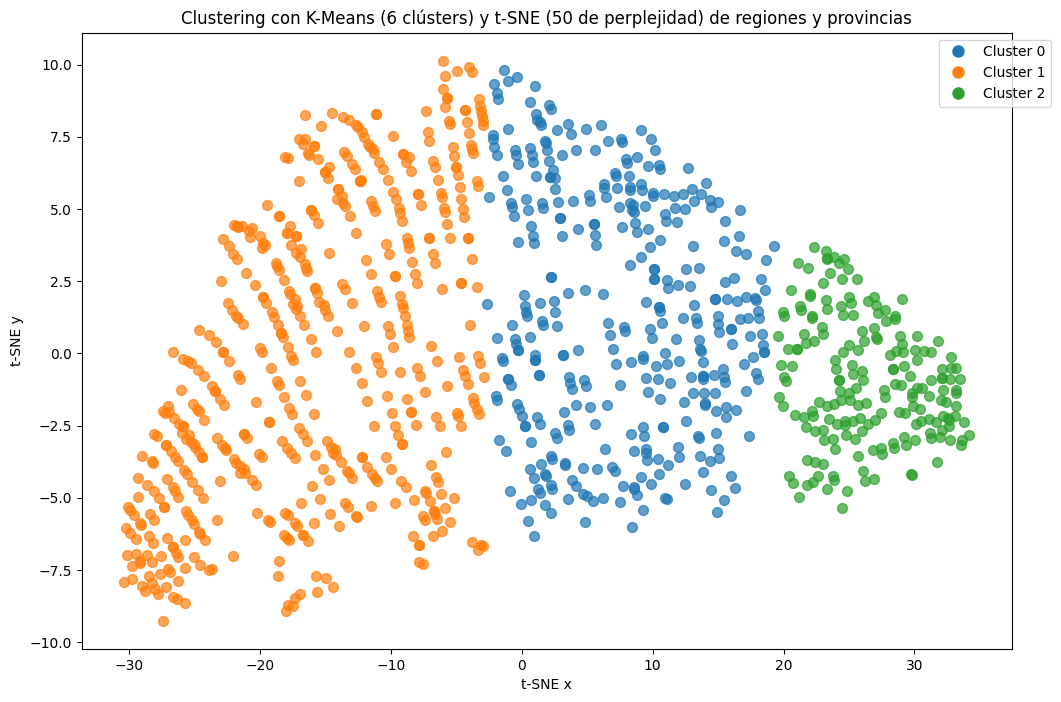

In [185]:
# Crea una figura con un solo subplot
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'],
                label=f'Cluster {cluster}', alpha=0.7, s=50)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{cluster}', markersize=10, label=f'Cluster {cluster}') for cluster in unique_clusters]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 1))
plt.title('Clustering con K-Means (6 clústers) y t-SNE (50 de perplejidad) de regiones y provincias')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.show()

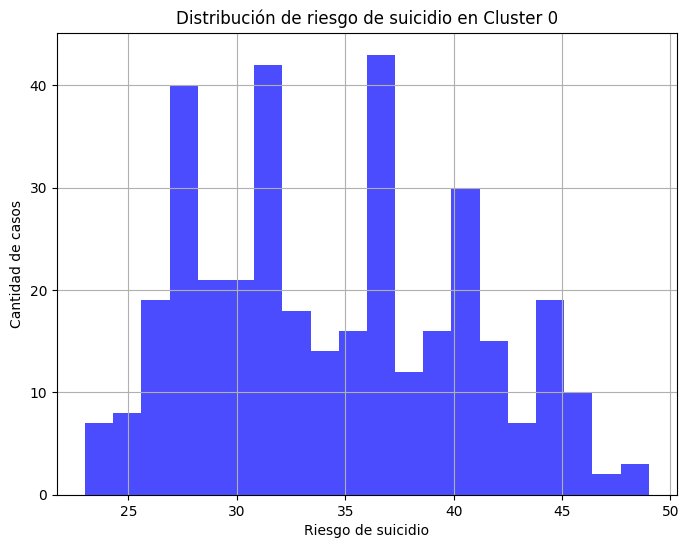

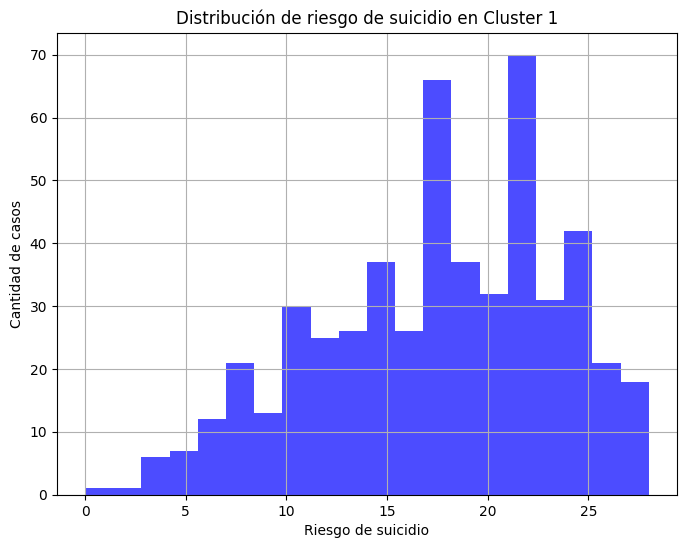

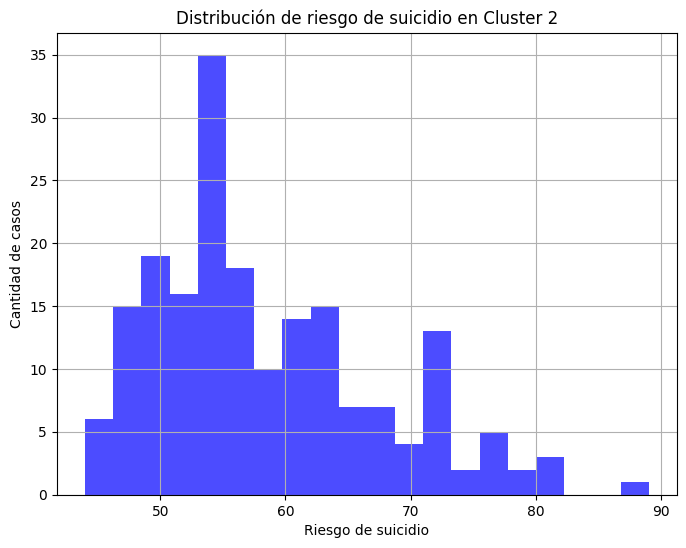

In [186]:
# Crea un gráfico de distribución de riesgo de suicidio en cada Cluster
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]

    plt.figure(figsize=(8, 6))
    plt.hist(cluster_data['SUIC RISK'], bins=20, color='blue', alpha=0.7)

    plt.title(f'Distribución de riesgo de suicidio en Cluster {cluster}')
    plt.xlabel('Riesgo de suicidio')
    plt.ylabel('Cantidad de casos')
    plt.grid(True)

    plt.show()

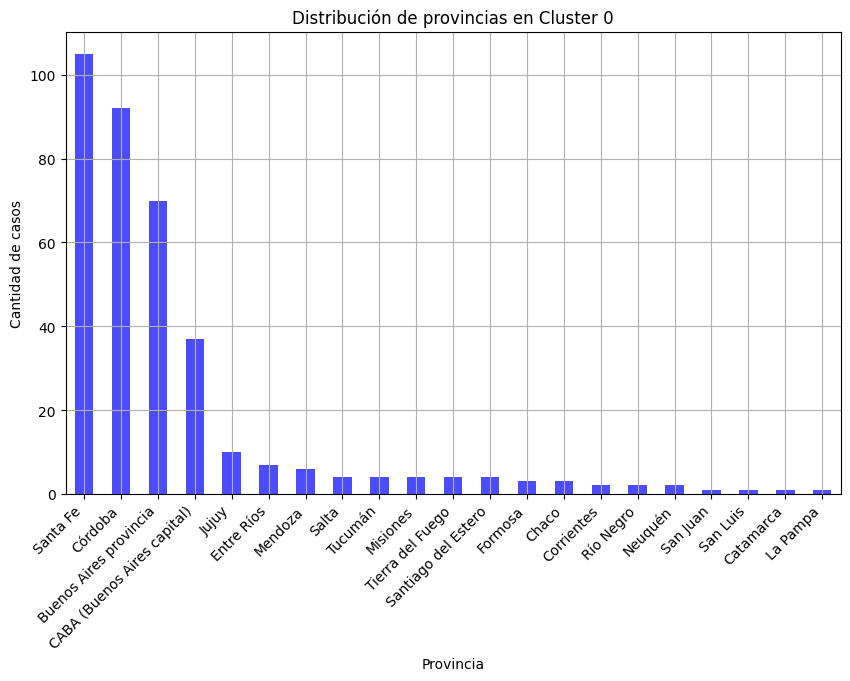

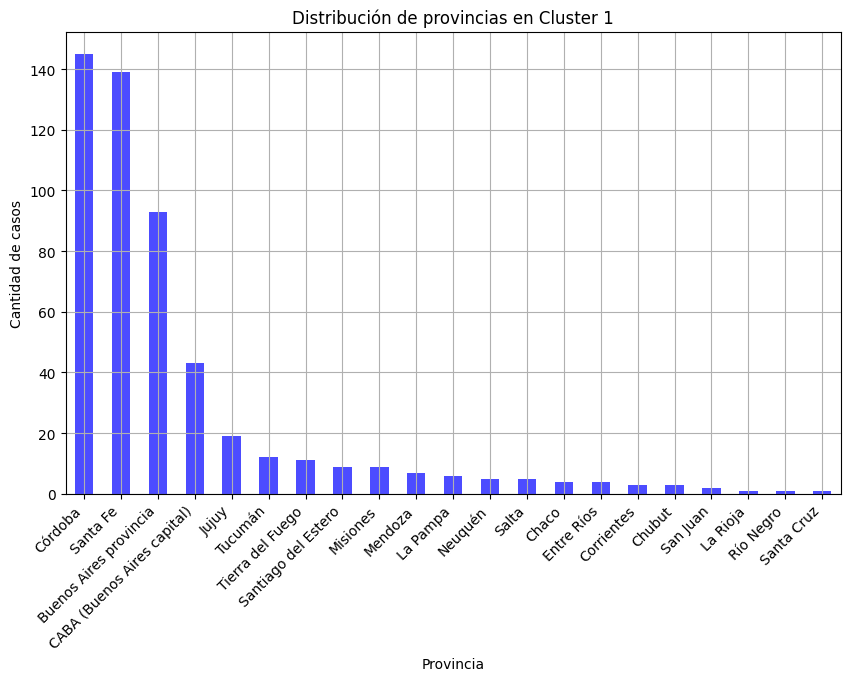

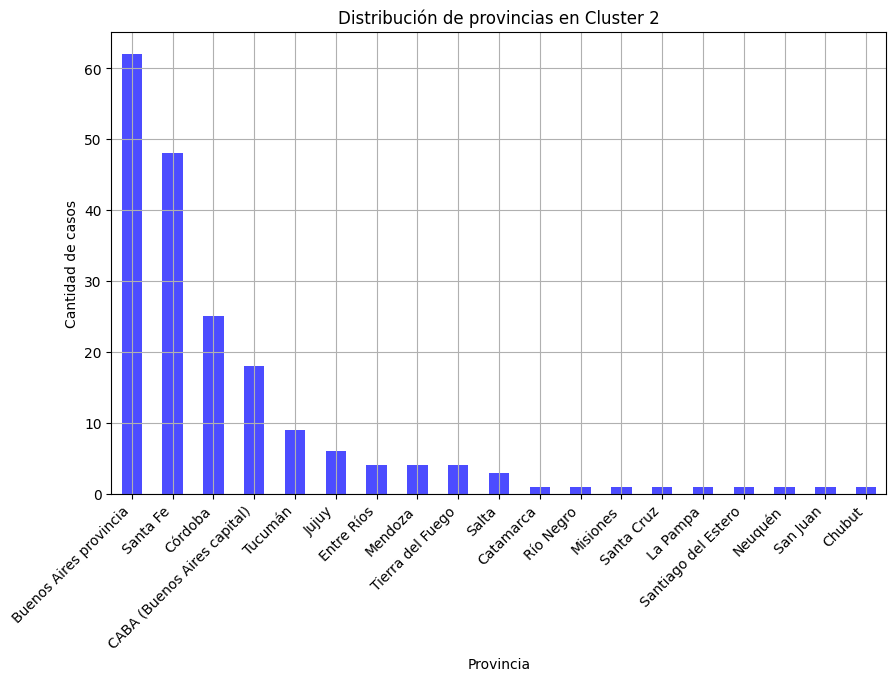

In [187]:
# Crea un gráfico de distribución de provincias para cada cluster
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    province_counts = cluster_data['PROVINCE'].value_counts()

    plt.figure(figsize=(10, 6))
    province_counts.plot(kind='bar', color='blue', alpha=0.7)

    plt.title(f'Distribución de provincias en Cluster {cluster}')
    plt.xlabel('Provincia')
    plt.ylabel('Cantidad de casos')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    plt.show()

In [189]:
# Encontrar el valor más alto de "SUIC RISK" en cada cluster
max_suic_risk = data_ref.groupby('Cluster')['SUIC RISK'].max()

# Imprimir los valores más altos de "SUIC RISK" por cluster
for cluster, value in max_suic_risk.items():
    print(f"Cluster {cluster}: Valor más alto de riesgo de suicidio: {value}")

Cluster 0: Valor más alto de riesgo de suicidio: 49
Cluster 1: Valor más alto de riesgo de suicidio: 28
Cluster 2: Valor más alto de riesgo de suicidio: 89


In [190]:
# Visualizar el registro completo con todas las variables para el valor más alto de "SUIC RISK" en cada cluster
for cluster, value in max_suic_risk.items():
    cluster_data = data_ref[(data_ref['Cluster'] == cluster) & (data_ref['SUIC RISK'] == value)]
    print(f"Cluster {cluster}: Valor más alto de SUIC RISK: {value}")
    print(cluster_data)

Cluster 0: Valor más alto de SUIC RISK: 49
     SUIC RISK  PROM SUIC  Cluster     tsne_x    tsne_y  \
190         49       23.0        0  19.235985  3.723637   

                   PROVINCE  EDUCATION  AGE  MENTAL DISORDER HISTORY  \
190  Buenos Aires provincia         60   20                        0   

     SUIC ATTEMPT HISTORY  LIVING WITH SOMEBODY  ECONOMIC INCOME  DEPRESSION  \
190                     0                     0                0          32   

     ANXIETY STATE  ANXIETY TRAIT        REGION  
190             38             31  Buenos Aires  
Cluster 1: Valor más alto de SUIC RISK: 28
     SUIC RISK  PROM SUIC  Cluster    tsne_x    tsne_y  \
47          28       16.4        1 -3.275954  8.824709   
344         28       14.0        1 -4.046346  9.910518   
476         28       16.8        1 -3.081053  8.409173   
485         28       17.0        1 -2.977852  8.042811   
549         28       14.4        1 -3.819227  9.738339   
860         28       16.7        1 -3.161